In [11]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [12]:
ind="stashcp-2016.7"
#new data
myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467834066930,
                  "lte": 1467842419537,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

#undirected
myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1468002935971,
                  "lte": 1468005422807,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

In [29]:
page= es.search(index=ind, body=myquery2, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

df = pd.DataFrame(Res)
#print(df.head(2))

del df['destination_space']
del df['xrdcp_version']
#del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
#del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(list(df.columns.values))
print(df.head(1))

996
['cache', 'download_time', 'end1', 'end2', 'filename', 'host', 'sitename', 'start1', 'start2', 'start3', 'status', 'timestamp', 'tries', 'xrdexit1', 'xrdexit2', 'xrdexit3', 'begin']
                                               cache download_time  \
0  root://mwt2-stashcache.campuscluster.illinois.edu         51548   

            end1 end2                           filename  \
0  1468002991303    0  user/taburaad/public/2gb_file.tar   

                                                host sitename         start1  \
0  root://mwt2-stashcache.campuscluster.illinois.edu   osg-ce  1468002939755   

  start2 start3   status      timestamp tries xrdexit1 xrdexit2 xrdexit3  \
0      0      0  Success  1468002991000     1        0       -1       -1   

           begin  
0  1468002939452  


In [33]:
begin=int(df['begin'].iloc[1])//1000
print(df['begin'].iloc[1])
print(begin)
print (datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S'))
#print (datetime.datetime.fromtimestamp(df['begin'].iloc[1]).strftime('%Y-%m-%d %H:%M:%S'))





1468002939267
1468002939
2016-07-08 13:35:39


In [28]:
length=df.shape[0]

for i in range(length):
    begin=int(df['begin'].iloc[i])//1000
    end=int(df['timestamp'].iloc[i])//1000
    start1=int(df['start1'].iloc[i])//1000
    end1=int(df['end1'].iloc[i])//1000
    start2=int(df['start2'].iloc[i])//1000
    end2=int(df['end2'].iloc[i])//1000
    start3=int(df['start3'].iloc[i])//1000
    df['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')  
    df['start1'].iloc[i]=datetime.datetime.fromtimestamp(start1).strftime('%Y-%m-%d %H:%M:%S')
    df['start2'].iloc[i]=datetime.datetime.fromtimestamp(start2).strftime('%Y-%m-%d %H:%M:%S')
    df['start3'].iloc[i]=datetime.datetime.fromtimestamp(start3).strftime('%Y-%m-%d %H:%M:%S')
    df['end1'].iloc[i]=datetime.datetime.fromtimestamp(end1).strftime('%Y-%m-%d %H:%M:%S')
    df['end2'].iloc[i]=datetime.datetime.fromtimestamp(end2).strftime('%Y-%m-%d %H:%M:%S')


    
df=df.set_index(['timestamp'])    
df.index = pd.to_datetime(df.index, unit='s')
df['begin']=pd.to_datetime(df['begin'], unit='s')
df['start1']=pd.to_datetime(df['start1'], unit='s')
df['start2']=pd.to_datetime(df['start2'], unit='s')
df['start3']=pd.to_datetime(df['start3'], unit='s')
df['end1']=pd.to_datetime(df.end1, unit='s')
df['end2']=pd.to_datetime(df.end2, unit='s')
df


/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,cache,download_time,end1,end2,filename,host,sitename,start1,start2,start3,status,tries,xrdexit1,xrdexit2,xrdexit3,begin
timestamp,,,,,,,,,,,,,,,,
2016-07-08 13:38:39,root://hcc-stash.unl.edu,113826,2016-07-08 13:38:39,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://hcc-stash.unl.edu,UTA_SWT2,2016-07-08 13:36:46,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:36:45
2016-07-08 13:38:43,root://mwt2-stashcache.campuscluster.illinois.edu,50499,2016-07-08 13:38:43,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-08 13:37:52,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:37:52
2016-07-08 13:38:42,root://mwt2-stashcache.campuscluster.illinois.edu,53488,2016-07-08 13:38:42,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-08 13:37:49,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:37:48
2016-07-08 13:38:51,root://data.ci-connect.net,115945,2016-07-08 13:38:51,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,NWICG_NDCMS,2016-07-08 13:36:55,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:36:55
2016-07-08 13:38:52,root://mwt2-stashcache.campuscluster.illinois.edu,55293,2016-07-08 13:38:52,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-08 13:37:56,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:37:56
2016-07-08 13:39:13,root://osgxroot.usatlas.bnl.gov,99143,2016-07-08 13:39:13,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://osgxroot.usatlas.bnl.gov,SU-OG-CE1,2016-07-08 13:37:34,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:37:33
2016-07-08 13:38:59,root://data.ci-connect.net,101718,2016-07-08 13:38:59,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,GLOW-OSG,2016-07-08 13:37:18,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:37:17
2016-07-08 13:39:03,root://hcc-stash.unl.edu,5,2016-07-08 13:39:03,2016-07-08 13:39:03,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,red-gateway1,2016-07-08 13:39:03,2016-07-08 13:39:03,2016-07-08 13:39:03,Timeout,3,127,127,127,2016-07-08 13:39:02
2016-07-08 13:39:04,root://osgxroot.usatlas.bnl.gov,206721,2016-07-08 13:39:04,1969-12-31 18:00:00,user/taburaad/public/2gb_file.tar,root://osgxroot.usatlas.bnl.gov,SU-OG-CE,2016-07-08 13:35:37,1969-12-31 18:00:00,1969-12-31 18:00:00,Success,1,0,-1,-1,2016-07-08 13:35:37


In [15]:
jobs = pd.concat([pd.Series(1, df.begin), pd.Series(-1, df.index)]).resample('1Min', how='sum').cumsum()
index=jobs.index

df2=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])
finish=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])

df2['index']=index
finish['index']=index

length2=df2.shape[0]
df2['Origin']=0
df2['Nebraska']=0
df2['UCSD']=0
df2['US-MWT2_UIUC']=0
df2['BNL ATLAS']=0
df2['FZU']=0
df2['Trunk']=0
finish['Origin']=0
finish['Nebraska']=0
finish['UCSD']=0
finish['US-MWT2_UIUC']=0
finish['BNL ATLAS']=0
finish['FZU']=0
finish['Trunk']=0
finish['Timeout']=0


for i in range(length2):
    for j in range(length):
        if df['tries'].iloc[j]=="1":
            if df['begin'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['host'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
                if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['host'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
        if df['tries'].iloc[j]=="3":
            if df['start1'].iloc[j]<=df2['index'].iloc[i] and df['end2'].iloc[j]>=df2['index'].iloc[i]:
                if df['cache'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['cache'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
            if df['start3'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                df2['Trunk'].iloc[i]+=1
        if df['tries'].iloc[j]=="2":
            if df['start2'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['cache'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['cache'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
        if df.index[j].replace(second=0, microsecond=0)==finish['index'].iloc[i].replace(second=0, microsecond=0):
            if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                finish['Nebraska'].iloc[i]+=1
            if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                finish['US-MWT2_UIUC'].iloc[i]+=1
            if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                finish['UCSD'].iloc[i]+=1
            if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                finish['BNL ATLAS'].iloc[i]+=1
            if df['host'].iloc[j]=='novastore.farm.particle.cz':
                finish['FZU'].iloc[i]+=1
            if df['host'].iloc[j]=='root://data.ci-connect.net':
                if df['status'].iloc[j]=='Timeout':
                    finish['Timeout'].iloc[i]+=1
                else:
                    if df['tries'].iloc[j]=="1" or df['tries'].iloc[j]=="2":
                        finish['Origin'].iloc[i]+=1
                    elif df['tries'].iloc[j]=="3":
                        finish['Trunk'].iloc[i]+=1


print('done')

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


done


In [21]:
df2

,index,Origin,Nebraska,UCSD,US-MWT2_UIUC,BNL ATLAS,FZU,Trunk
0,2016-07-08 13:34:00,0,0,0,0,0,0,0
1,2016-07-08 13:35:00,0,0,0,0,1,0,0
2,2016-07-08 13:36:00,6,1,1,4,11,0,0
3,2016-07-08 13:37:00,4,1,0,4,13,0,0
4,2016-07-08 13:38:00,6,1,0,3,14,0,0
5,2016-07-08 13:39:00,25,1,0,5,25,0,0
6,2016-07-08 13:40:00,36,1,4,3,40,0,0
7,2016-07-08 13:41:00,37,1,2,5,42,0,0
8,2016-07-08 13:42:00,37,2,1,12,46,0,1
9,2016-07-08 13:43:00,37,2,1,8,48,0,1


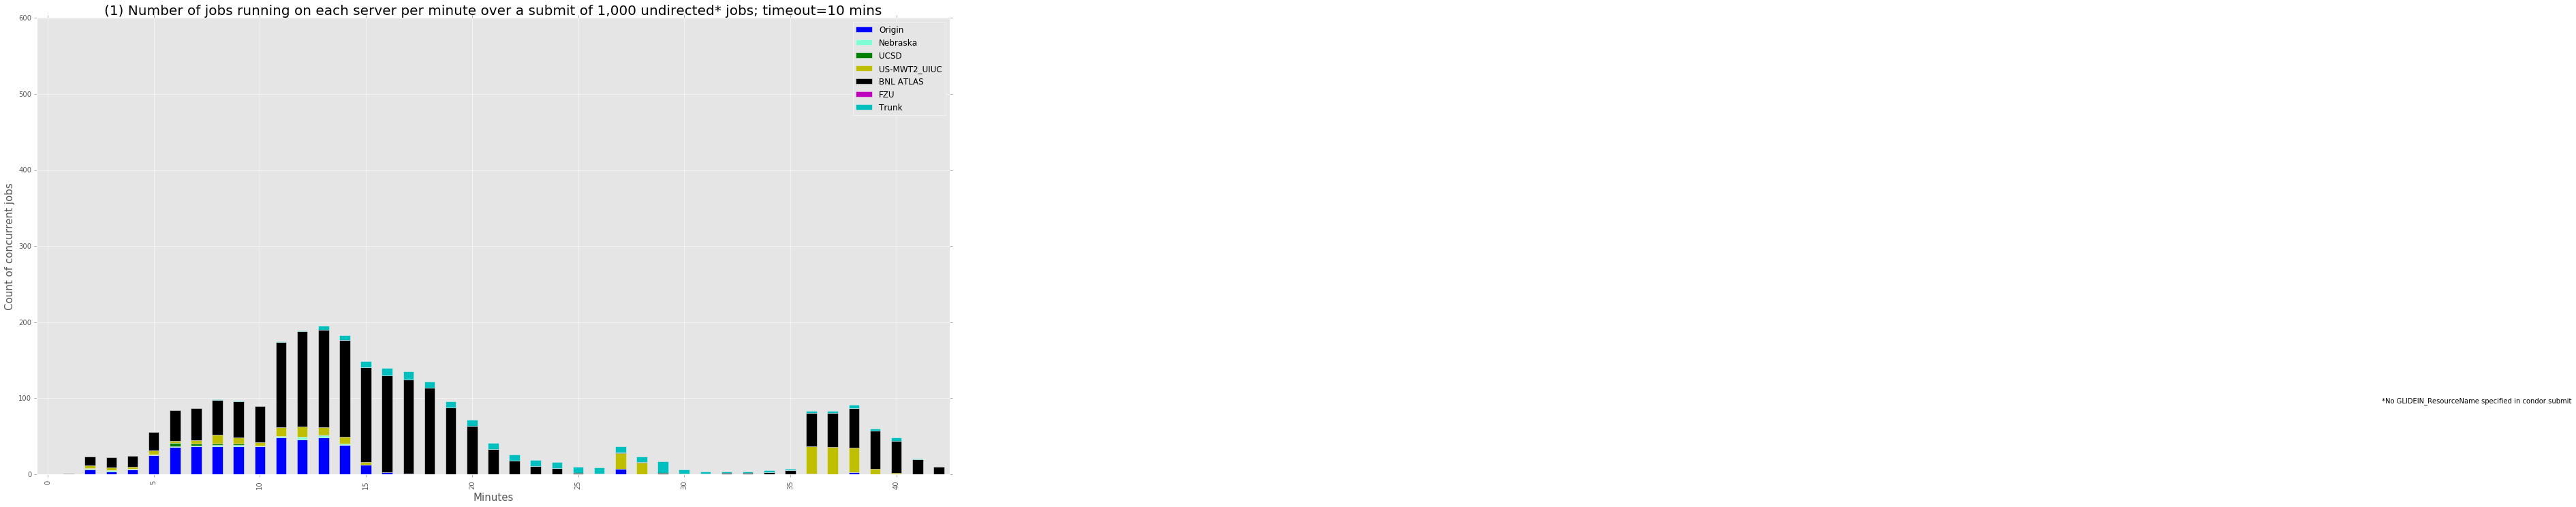

In [20]:
df2.plot.bar(stacked=True,figsize=[24, 12],color=['b', '#7FFFD4', 'g', 'y', 'k', 'm', 'c'])
plt.title('(1) Number of jobs running on each server per minute over a submit of 1,000 undirected* jobs; timeout=10 mins', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of concurrent jobs',fontsize=15)
plt.text(110,95,'*No GLIDEIN_ResourceName specified in condor.submit')

plt.ylim([0,600])
plt.xticks(np.arange(0, length2+1, 5),np.arange(0, length2+1, 5))

plt.savefig('undirected_concurrent_1min.png')
plt.show()


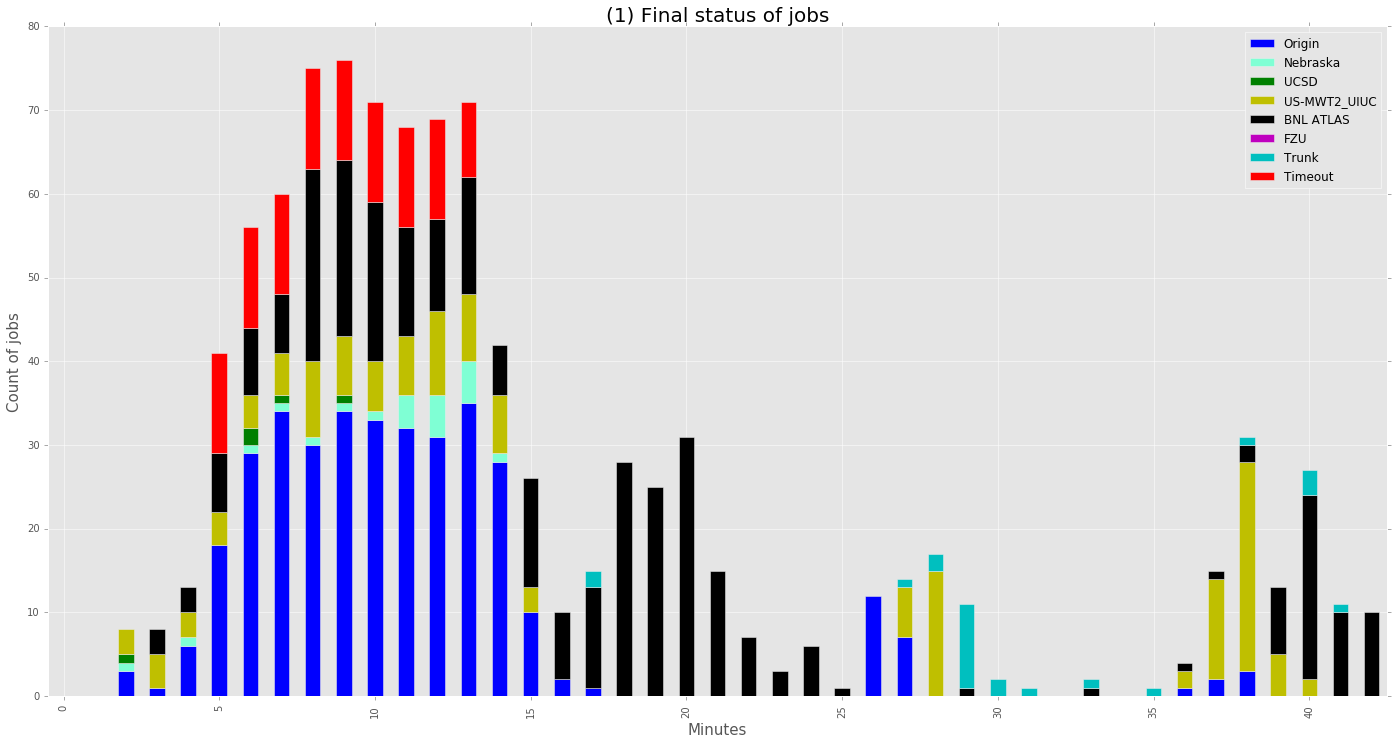

In [18]:
finish.plot.bar(stacked=True,figsize=[24, 12],color=['b', '#7FFFD4', 'g', 'y', 'k', 'm', 'c', 'r'])
plt.title('(1) Final status of jobs', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of jobs',fontsize=15)
plt.xticks(np.arange(0, length2+1, 5),np.arange(0, length2+1, 5))
plt.show()


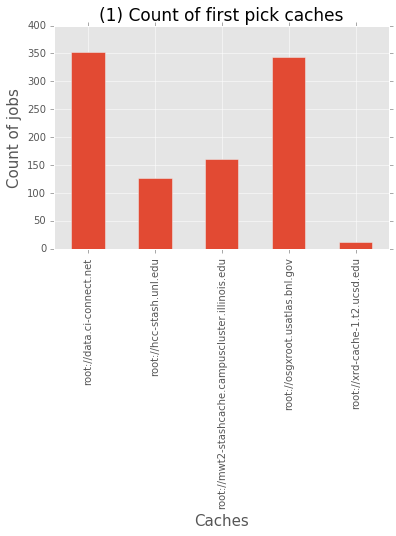

In [19]:
caches=df.groupby(['cache'])['cache'].count()
caches.plot.bar()
plt.title('(1) Count of first pick caches', fontsize=17) 
plt.xlabel('Caches', fontsize=15)
plt.ylabel('Count of jobs',fontsize=15)
plt.show()